In [6]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os

# --------------------------
# Load Metadata
# --------------------------
metadata_path = r"C:\Users\adity\Downloads\covid-chestxray-dataset-master\covid-chestxray-dataset-master\metadata.csv"
image_dir = r"C:\Users\adity\Downloads\covid-chestxray-dataset-master\covid-chestxray-dataset-master\images"

metadata = pd.read_csv(metadata_path)
metadata = metadata[['filename', 'finding']].rename(columns={'filename':'image_path'})
metadata = metadata[metadata['image_path'].notna()]
metadata['image_path'] = metadata['image_path'].apply(lambda x: os.path.join(image_dir, x))

# Filter classes with at least N images
min_samples = 5
class_counts = metadata['finding'].value_counts()
valid_classes = class_counts[class_counts >= min_samples].index
metadata = metadata[metadata['finding'].isin(valid_classes)]
print(f"Classes used: {list(valid_classes)}")

# --------------------------
# Train/Validation Split
# --------------------------
train_df, val_df = train_test_split(
    metadata,
    test_size=0.2,
    stratify=metadata['finding'],
    random_state=42
)
print("Train samples per class:")
print(train_df['finding'].value_counts())
print("Validation samples per class:")
print(val_df['finding'].value_counts())

# --------------------------
# Data Generators
# --------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
val_datagen = ImageDataGenerator(rescale=1./255)

all_classes = list(metadata['finding'].unique())

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='finding',
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical',
    classes=all_classes
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='finding',
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical',
    classes=all_classes,
    shuffle=False
)

# --------------------------
# Compute Class Weights
# --------------------------
y_train = train_generator.classes
classes_present = np.unique(y_train)
class_weights_values = compute_class_weight(
    class_weight='balanced',
    classes=classes_present,
    y=y_train
)
class_weights = dict(zip(classes_present, class_weights_values))
print("Class weights:", class_weights)

# --------------------------
# Weighted Loss Function
# --------------------------
from tensorflow.keras import backend as K

def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given positive and negative weights.
    """
    def weighted_loss(y_true, y_pred):
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        loss = 0.0
        for i in range(len(pos_weights)):
            loss_pos = - K.mean(pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i]))
            loss_neg = - K.mean(neg_weights[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i]))
            loss += loss_pos + loss_neg
        return loss
    return weighted_loss

# Example weights (can tune according to imbalance)
pos_weights = np.array([2.0]*len(all_classes))
neg_weights = np.array([1.0]*len(all_classes))

# --------------------------
# Build DenseNet121 Model
# --------------------------
base_model = DenseNet121(weights=None, include_top=False, input_shape=(224,224,3))
x = GlobalAveragePooling2D()(base_model.output)
predictions = Dense(len(all_classes), activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos_weights, neg_weights),
    metrics=['accuracy']
)

model.summary()

# --------------------------
# Train the Model
# --------------------------
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    class_weight=class_weights
)


Classes used: ['Pneumonia/Viral/COVID-19', 'todo', 'Pneumonia', 'Pneumonia/Fungal/Pneumocystis', 'Pneumonia/Bacterial/Streptococcus', 'No Finding', 'Tuberculosis', 'Pneumonia/Viral/SARS', 'Pneumonia/Lipoid', 'Pneumonia/Bacterial/Mycoplasma', 'Pneumonia/Viral/MERS-CoV', 'Pneumonia/Bacterial/Klebsiella', 'Pneumonia/Bacterial/Legionella', 'Pneumonia/Bacterial/Nocardia', 'Pneumonia/Viral/Varicella', 'Pneumonia/Viral/Influenza']
Train samples per class:
finding
Pneumonia/Viral/COVID-19             467
todo                                  66
Pneumonia                             65
Pneumonia/Fungal/Pneumocystis         24
Pneumonia/Bacterial/Streptococcus     18
No Finding                            18
Tuberculosis                          14
Pneumonia/Viral/SARS                  13
Pneumonia/Lipoid                      10
Pneumonia/Bacterial/Mycoplasma         9
Pneumonia/Bacterial/Klebsiella         8
Pneumonia/Bacterial/Legionella         8
Pneumonia/Viral/MERS-CoV               8
Pneumo

Found 161 validated image filenames belonging to 16 classes.
Class weights: {0: 0.09694767441860465, 1: 0.7865566037735849, 2: 3.206730769230769, 3: 1.9851190476190477, 4: 2.3159722222222223, 5: 2.779166666666667, 6: 5.955357142857143, 7: 5.955357142857143, 8: 4.631944444444445, 9: 8.3375, 10: 4.631944444444445, 11: 10.421875, 12: 0.71875, 13: 3.4739583333333335, 14: 8.3375, 15: 41.6875}


c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 76 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(
c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 25 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,053,904 (26.91 MB)

 Trainable params: 6,970,256 (26.59 MB)

 Non-trainable params: 83,648 (326.75 KB)

c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.5394 - loss: 4.3550 - val_accuracy: 0.5280 - val_loss: 38.1811
Epoch 2/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.6487 - loss: 3.4342 - val_accuracy: 0.3478 - val_loss: 21.0669
Epoch 3/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.6594 - loss: 3.3120 - val_accuracy: 0.5776 - val_loss: 16.5451
Epoch 4/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.6976 - loss: 3.1911 - val_accuracy: 0.6335 - val_loss: 9.4355
Epoch 5/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.6597 - loss: 3.0575 - val_accuracy: 0.1429 - val_loss: 15.8717
Epoch 6/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.6424 - loss: 3.3018 - val_accuracy: 0.1615 - val_loss: 16.1325
Epoch 7/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.6257 - loss: 3.2010 - val_accuracy: 0.6149 - val_loss: 5.7638
Epoch 8/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.6377 - loss: 3.2338 - val_accuracy: 0.6398 - val

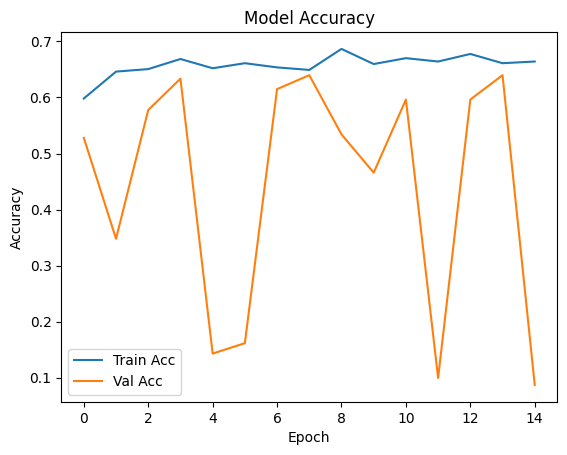

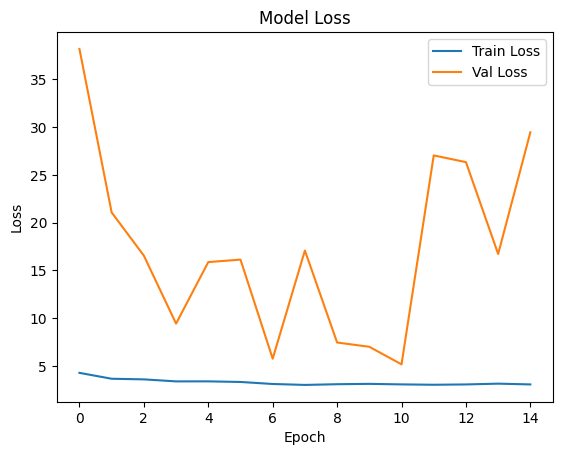

In [7]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on validation set
val_preds = model.predict(val_generator)
val_preds_classes = np.argmax(val_preds, axis=1)
true_classes = val_generator.classes

# Only use classes actually present in validation
unique_labels = np.unique(true_classes)
present_class_labels = [all_classes[i] for i in unique_labels]

print(classification_report(true_classes, val_preds_classes, labels=unique_labels, target_names=present_class_labels))


11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 575ms/step
                                   precision    recall  f1-score   support

         Pneumonia/Viral/COVID-19       0.00      0.00      0.00       103
                        Pneumonia       0.00      0.00      0.00        15
             Pneumonia/Viral/SARS       0.00      0.00      0.00         3
    Pneumonia/Fungal/Pneumocystis       0.00      0.00      0.00         4
Pneumonia/Bacterial/Streptococcus       0.00      0.00      0.00         4
                       No Finding       0.00      0.00      0.00         3
   Pneumonia/Bacterial/Klebsiella       0.00      0.00      0.00         2
   Pneumonia/Bacterial/Legionella       0.00      0.00      0.00         2
                 Pneumonia/Lipoid       0.00      0.00      0.00         2
        Pneumonia/Viral/Varicella       0.00      0.00      0.00         1
   Pneumonia/Bacterial/Mycoplasma       0.00      0.00      0.00         1
                             todo       0.09      0.88    

C:\Users\adity\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\adity\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\adity\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

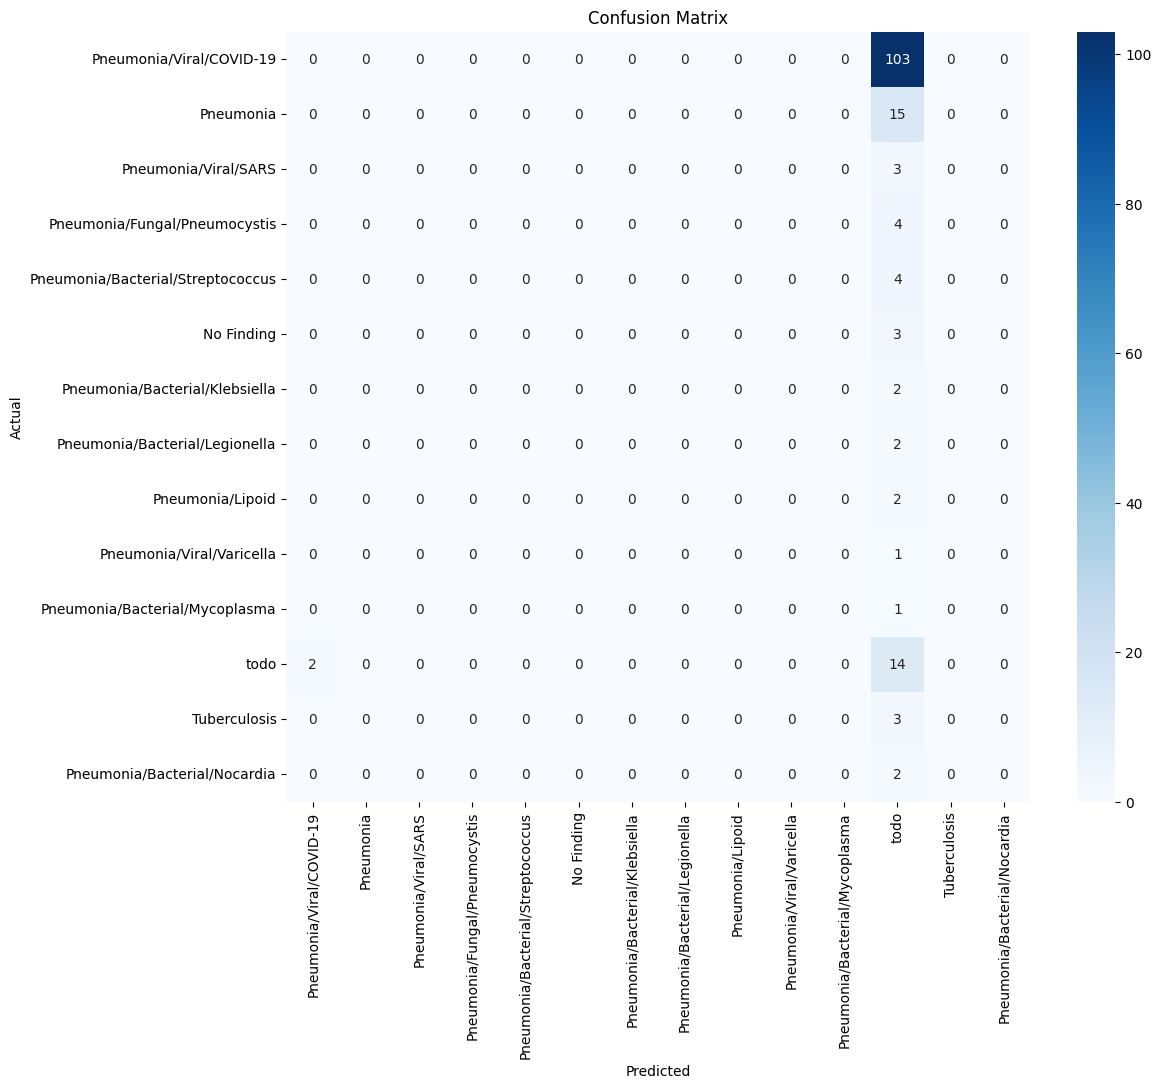

In [9]:
cm = confusion_matrix(true_classes, val_preds_classes, labels=unique_labels)
import seaborn as sns

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=present_class_labels, yticklabels=present_class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [10]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = r"C:\Users\adity\Downloads\covid-chestxray-dataset-master\covid-chestxray-dataset-master\images\nejmc2001573_f1b.jpeg"
img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
pred_class = all_classes[np.argmax(pred)]
print("Predicted Class:", pred_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: Pneumonia/Viral/COVID-19
